# Loading images, masking, and circle detection in OpenCV 

This tutorial demonstrates how to detect colored objects—in this case, red and blue balls—using OpenCV. It is designed for beginners who are just starting with computer vision. The code covers several fundamental concepts:

1. **Loading and Converting Images:**  
   The script begins by importing necessary libraries (NumPy, OpenCV, and Matplotlib) and loading an image using `cv2.imread()`. The image is then converted from OpenCV’s default BGR color space to the HSV (Hue, Saturation, Value) color space, which makes it easier to isolate specific colors under different lighting conditions.

2. **Creating Color Masks:**  
   Binary masks are created using `cv2.inRange()` to isolate the blue and red regions in the image. For the blue ball, a single range is defined. Since the red hue wraps around the HSV color spectrum, two separate ranges are defined and then combined to capture all shades of red.

3. **Applying Morphological Operations:**  
   Morphological operations (opening and closing) are applied using `cv2.morphologyEx()` with a predefined kernel. These operations help remove small noise from the masks and fill in gaps, ensuring that the masks accurately represent the colored objects.

4. **Contour Detection and Object Identification:**  
   The function `detect_ball()` finds contours in each mask using `cv2.findContours()`, sorts them by area, and assumes the largest contour corresponds to the ball. It then computes the minimum enclosing circle for the largest contour, draws the circle and its center on the image, and labels the detected ball.

5. **Displaying the Result:**  
   Finally, the processed image (with the detected balls highlighted) is converted from BGR to RGB and displayed using Matplotlib’s `plt.imshow()`.

This step-by-step approach introduces essential OpenCV techniques including image loading, color space conversion, thresholding, morphological operations, contour detection, and drawing functions, making it an excellent starting point for newcomers to computer vision.


# 1. What is an image? 

In [ ]:
! pip install opencv-python

In [ ]:
import cv2 # this is the OpenCV library
import numpy as np # this is the NumPy library
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks. 
# OPENCV uses BGR instead of RGB. 
# OpenCV also has a plotting function but it works worse in the notebooks.

: 

Image shape: (2164, 3064, 3)


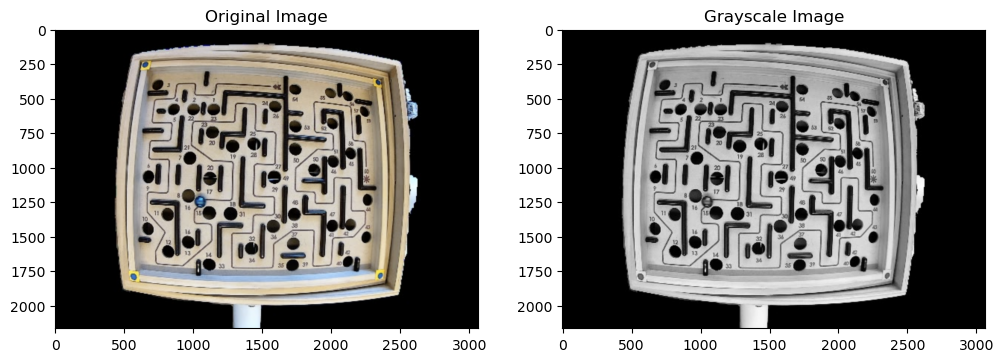

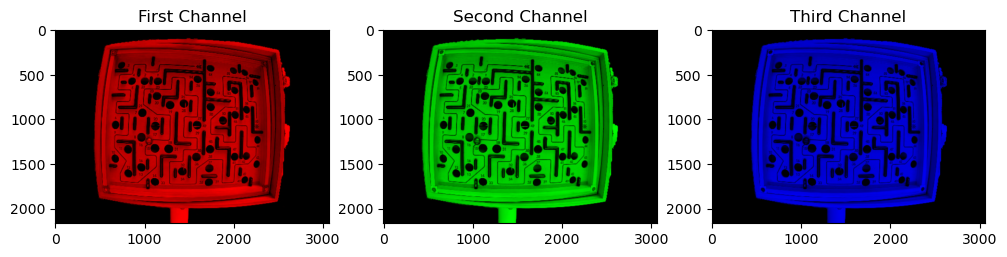

In [23]:
# Load the image
image = cv2.imread("only_blue.png")

print("Image shape:", image.shape)

# Convert image to grayscale (HoughCircles works on single channel images)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# plot two images side by side
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.subplot(122)
plt.imshow(gray, cmap='gray')
plt.title("Grayscale Image")
plt.show()

# print the three colours separately side by side on subplots
plt.figure(figsize=(12,6))
plt.subplot(131)
red = np.zeros_like(image)
red[:,:,0] = image[:,:,0]
plt.imshow(red, cmap='gray')
plt.title("First Channel")
plt.subplot(132)
green = np.zeros_like(image)
green[:,:,1] = image[:,:,1]
plt.imshow(green, cmap='gray')
plt.title("Second Channel")
plt.subplot(133)
blue = np.zeros_like(image)
blue[:,:,2] = image[:,:,2]
plt.imshow(blue, cmap='gray')
plt.title("Third Channel")
plt.show()




# Detecting circles on an image: the HoughCircles algorithm

https://docs.opencv.org/4.x/da/d53/tutorial_py_houghcircles.html is the documentation from OpenCV

Circles are a "feature" and OpenCV is a library which specializes in fast and automatic feature detection, as explained here: 

https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d


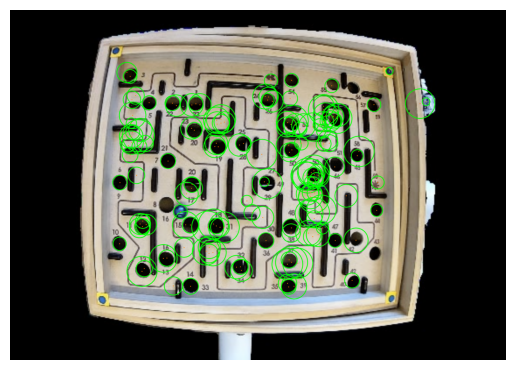

In [ ]:

# Optionally, we can apply a Gaussian blur to reduce noise and improve detection accuracy
#  this can help us test the robustness of our algorithn.
# gray_blurred = cv2.GaussianBlur(gray, (9, 9), 2)

# Detect circles using HoughCircles
circles = cv2.HoughCircles(
    gray, 
    cv2.HOUGH_GRADIENT, 
    dp=1.2,           # Inverse ratio of the accumulator resolution to the image resolution
    minDist=20,       # Minimum distance between the centers of the detected circles
    param1=100,       # Higher threshold for the Canny edge detector (the lower one is half)
    param2=50,        # Accumulator threshold for circle detection (smaller -> more false circles)
    minRadius=10,     # Minimum circle radius (adjust based on your image)
    maxRadius=100     # Maximum circle radius (adjust based on your image)
)

# If circles are detected, draw them on the image
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        # Draw the outer circle
        cv2.circle(image, (x, y), r, (0, 255, 0), 4)
        # Draw the center of the circle
        cv2.rectangle(image, (x - 2, y - 2), (x + 2, y + 2), (0, 128, 255), -1)

# Show the output image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()





Clearly this isn't good enough. What are the things that went wrong? 
1. empty spaces and mild local consistancies in lighting and shadows can seem like circles. 
2. there are plenty of holes that are also circle-shaped. 

We should therefore adapt our apporach to be based on the techique called masking. We will single out a single color, or range of colors and look for circes on the masked image. 

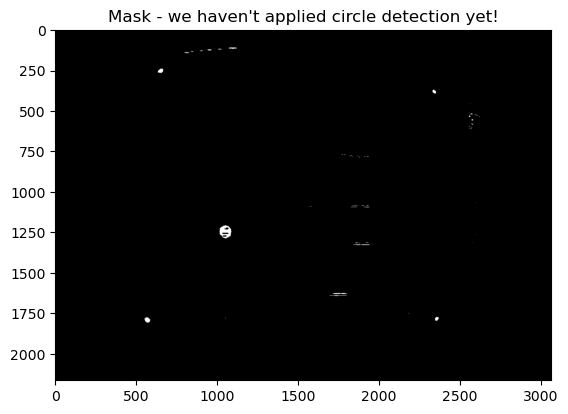

In [10]:

# Read the image
image = cv2.imread("only_blue.png")

# Convert BGR to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define lower and upper bounds for "blue" in HSV
# NOTE: These values are just typical examples; you should calibrate them for your lighting conditions.
lower_blue = np.array([100, 150, 50])  
upper_blue = np.array([140, 255, 255]) 

# Create a mask where only blue is white and everything else is black
mask = cv2.inRange(hsv, lower_blue, upper_blue)


# plot the mask using plt
plt.imshow(mask, cmap='gray')
plt.title("Mask - we haven't applied circle detection yet!")
plt.show()



circles detected on the masked image: 
 [[[1050.6001 1242.6001   33.28  ]]]


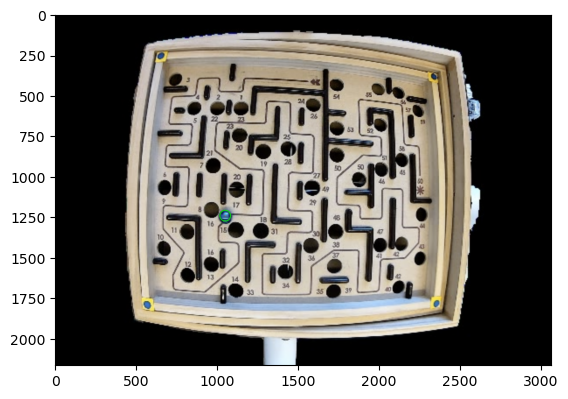

In [11]:
# Detect circles using HoughCircles
circles = cv2.HoughCircles(
    mask, 
    cv2.HOUGH_GRADIENT, 
    dp=1.2,           # Inverse ratio of the accumulator resolution to the image resolution
    minDist=50,       # Minimum distance between the centers of the detected circles
    param1=100,       # Higher threshold for the Canny edge detector (the lower one is half)
    param2=30,        # Accumulator threshold for circle detection (smaller -> more false circles)
    minRadius=10,     # Minimum circle radius (adjust based on your image)
    maxRadius=100     # Maximum circle radius (adjust based on your image)
)

print("circles detected on the masked image: \n", circles)
# If circles are detected, draw them on the image
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        # Draw the outer circle
        cv2.circle(image, (x, y), r, (0, 255, 0), 4)
        # Draw the center of the circle
        cv2.rectangle(image, (x - 2, y - 2), (x + 2, y + 2), (0, 128, 255), -1)

# Show the output image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# Problem 2: what if we have two different balls on the same board?

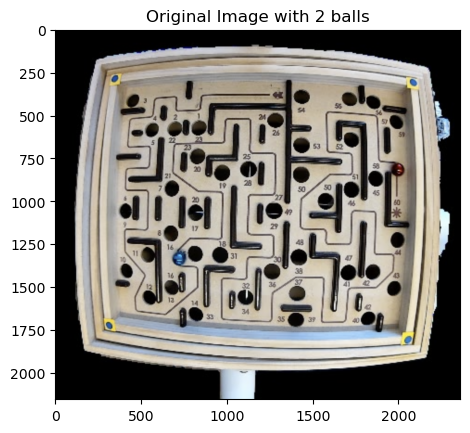

In [12]:

# Load the image
image = cv2.imread("red_and_blue.png")

# Convert to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

#plot the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image with 2 balls")
plt.show()




We will apply two masks at the same time -- one for the color blue and look for the blue ball there and one for the red ball and look for the red ball on the second masked image. We can look for the balls there and then use the information to detect the balls on the original image.

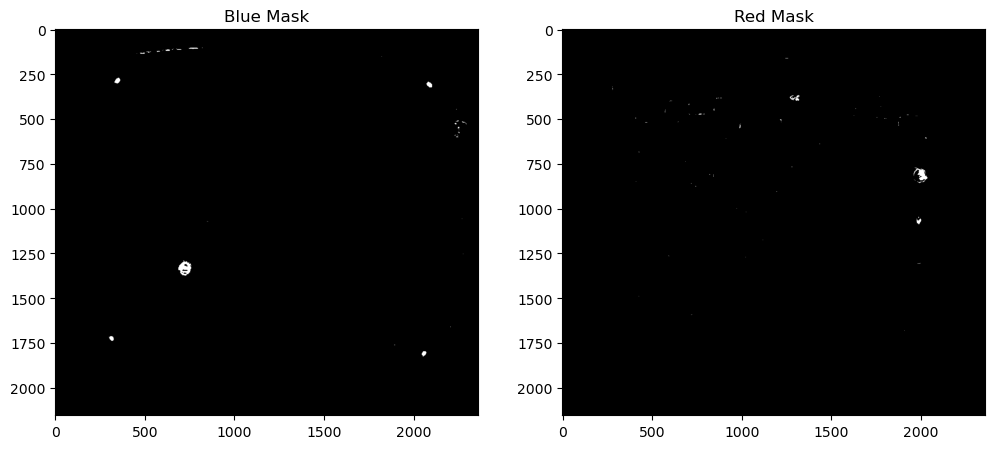

Detected Blue ball at (726, 1335) with radius 39
Detected Red ball at (2012, 812) with radius 33


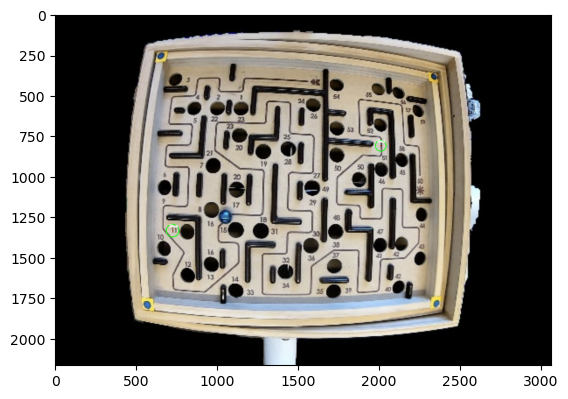

In [25]:
# -------------------------------------------------------------
# 1) Create a mask for the BLUE ball
# -------------------------------------------------------------
# We can adjust these ranges to match the lighting conditions and the hue of the ball
lower_blue = np.array([100, 150, 50])   
upper_blue = np.array([140, 255, 255])
mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

# -------------------------------------------------------------
# 2) Create a mask for the RED ball
# -------------------------------------------------------------
# Red color can wrap around the hue range, so we typically use two ranges and combine
# Range 1 (low-end reds)
# Range 1 (low-end reds)
lower_red1 = np.array([0, 70, 50])    # Lower S & V so darker reds are included
upper_red1 = np.array([10, 255, 255])

# Range 2 (high-end reds)
lower_red2 = np.array([170, 70, 50])  # Lower S & V here as well
upper_red2 = np.array([180, 255, 255])

mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)

mask_red = mask_red1 + mask_red2

# plot the two masks side by side
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(mask_blue, cmap='gray')
plt.title("Blue Mask")
plt.subplot(122)
plt.imshow(mask_red, cmap='gray')
plt.title("Red Mask")
plt.show()


# -------------------------------------------------------------
# 3) Clean up the masks with morphological operations
# -------------------------------------------------------------
kernel = np.ones((5,5), np.uint8)

# For blue
mask_blue = cv2.morphologyEx(mask_blue, cv2.MORPH_OPEN, kernel, iterations=2)
mask_blue = cv2.morphologyEx(mask_blue, cv2.MORPH_CLOSE, kernel, iterations=2)

# For red
mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_OPEN, kernel, iterations=2)
mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_CLOSE, kernel, iterations=2)

# -------------------------------------------------------------
# 4) Detect the ball by finding contours (or circles) in each mask
# -------------------------------------------------------------
def detect_ball(mask, output_image, color_name):
    """
    Finds the largest contour in 'mask', encloses it with a circle,
    and draws it on 'output_image'.
    """
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    
    if not contours:
        return
    
    # Sort contours by area (descending)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    
    # We'll assume the largest contour is our ball
    largest_contour = contours[0]
    area = cv2.contourArea(largest_contour)
    

    # Find the circle enclosing the contour
    ((x, y), radius) = cv2.minEnclosingCircle(largest_contour)
    center = (int(x), int(y))
    radius = int(radius)
    
    print(f"Detected {color_name} ball at {center} with radius {radius}")
    
    # Draw the circle and center
    cv2.circle(output_image, center, radius, (0, 255, 0), 3)
    cv2.circle(output_image, center, 3, (0, 0, 255), -1)
    
    # Label it
    cv2.putText(output_image, color_name, (center[0] - 20, center[1] - 20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

# Detect Blue Ball
detect_ball(mask_blue, image, "Blue")

# Detect Red Ball
detect_ball(mask_red, image, "Red")

# -------------------------------------------------------------
# 5) Show results
# -------------------------------------------------------------
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


